<center>
<h2>Capstone Project</h2>

# <span style='color: #81A5FF; '> ❔ Defining Personalities through a Predictive Model </span>

<h3> Group 4 </h3>

<span style='color: #081F4F; font-size: 18px;'>2023/2024</span>
</center>


---------

## Table of Contents

The following notebook concerns the manipulation of questionnaire data provided by ChatGPT in an effort to build a classifier able to predict which "Food Personality" a customer fits in, thus consisting of a typical Machine Learning pipeline.

<span style = 'font-size: 18px;'>

1. [🍽️ Importing Libraries and Integrating Data](#data-import)
2. [🍽️ Preliminary Exploration of the Data](#explore)
3. [🍽️ Visualizing Patterns](#visualization)
4. [🍽️ Building the Classifier and Evaluating it](#classifier)
4. [🍽️ Training and Saving the Final Model](#save)
</span>


---------

### 1. 🍽️ Importing Libraries and Integrating Data <a class="anchor" id="data-import"></a>
[Back to TOC](#toc)

In [46]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import string


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,  confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> Firstly, we will extract the AI generated questionnaire answers, their augmentations and structure all of them together.

In [47]:
#Extracting the AI generated answers
answers = pd.DataFrame()
for personality in os.listdir('data/training_answers/original/'):
    personality_answer = pd.read_csv('data/training_answers/original/' + personality)
    personality_answer['personality'] = personality
    answers = pd.concat([answers,personality_answer])

In [48]:
answers

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,personality
0,2,3,4,2,3,5,2,3,5,3,comfort_food_lover_responses.csv
1,1,2,3,1,2,4,1,2,4,2,comfort_food_lover_responses.csv
2,2,3,4,2,3,5,2,3,5,3,comfort_food_lover_responses.csv
3,3,2,3,3,2,4,1,4,4,2,comfort_food_lover_responses.csv
4,1,3,4,1,3,5,2,2,5,3,comfort_food_lover_responses.csv
...,...,...,...,...,...,...,...,...,...,...,...
16,5,3,4,4,3,4,5,3,3,3,the_adventurer_responses.csv
17,5,3,3,2,4,3,5,2,3,5,the_adventurer_responses.csv
18,5,4,3,3,3,3,5,3,4,4,the_adventurer_responses.csv
19,4,3,2,4,3,4,5,3,3,2,the_adventurer_responses.csv


In [49]:
#Extracting the augmented answers provided by AI content
answers_aug = pd.DataFrame()
for personality in os.listdir('data/training_answers/aug/'):
    personality_answer = pd.read_csv('data/training_answers/aug/' + personality)
    personality_answer['personality'] = personality
    answers_aug = pd.concat([answers_aug,personality_answer])

In [50]:
answers_aug

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,personality
0,3,2,4,1,2,4,1,4,4,3,comfort_food_lover_responses_aug.csv
1,1,2,3,1,2,4,1,2,4,2,comfort_food_lover_responses_aug.csv
2,3,2,3,3,2,4,1,4,4,2,comfort_food_lover_responses_aug.csv
3,1,2,3,1,2,4,1,2,4,2,comfort_food_lover_responses_aug.csv
4,2,3,4,2,3,5,2,3,5,3,comfort_food_lover_responses_aug.csv
...,...,...,...,...,...,...,...,...,...,...,...
4995,5,4,3,3,3,3,5,4,4,4,the_adventurer_responses_aug.csv
4996,5,3,3,2,3,2,5,3,3,2,the_adventurer_responses_aug.csv
4997,4,3,3,4,3,4,5,3,3,4,the_adventurer_responses_aug.csv
4998,5,3,3,5,3,3,5,3,2,3,the_adventurer_responses_aug.csv


In [51]:
# Joining the two datasets
total_answers = pd.concat([answers,answers_aug])

In [52]:
# Resetting the index of the dataframe
total_answers.reset_index(inplace=True, drop=True)

In [53]:
# Putting the personality classes in a more readable format
personality_mapping_names = {}
for personality in list(total_answers['personality'].unique()):
    name = personality.split('_')[:-1]
    name_clean = []
    for section in name:
        section = section.capitalize()
        if section != 'Responses':
            name_clean.append(section)
    name_clean = ' '.join(name_clean)
    personality_mapping_names[personality] = name_clean
total_answers['personality'] = total_answers['personality'].map(personality_mapping_names)

In [54]:
# Exporting the total_answers to a CSV file to introduce them to ChatGPT and generate some noisy observations
total_answers.to_csv('data/training_answers/total_answers', index=False)

In [55]:
# Importing the data with additional noise introduced to the answers by ChatGPT
final_answers = pd.read_csv('data/training_answers/perturbed_total_answers.csv')

> Let's add random usernames as identifiers of the observations.

In [56]:
existing_usernames = set() 

def generate_username(length=10):
    characters = string.ascii_letters + string.digits  
    while True:
        username = ''.join(random.choice(characters) for _ in range(length))
        if username not in existing_usernames:
            existing_usernames.add(username)
            return username

# Generating a column with random usernames for the answers
final_answers['username'] = final_answers.apply(lambda x: generate_username(), axis=1)

> Now let's export the processed data for further usage in other phases of the project.

In [57]:
# Exporting the 'final_answers' DataFrame to a CSV file
final_answers.to_csv('data/training_answers/perturbed_total_answers.csv', index=False)

### 2. 🍽️ Preliminary Exploration and Preprocessement <a class="anchor" id="explore"></a>
[Back to TOC](#toc)

In [58]:
final_answers['personality'].value_counts()

personality
Comfort Food Lover         5021
Conscious Eater            5021
Fine Dining Connoisseur    5021
Low Cost Foodie            5021
The Adventurer             5021
Name: count, dtype: int64

> We find that our data is perfectly balanced, making it appropriate to examine metrics such as the accuracy.

In [59]:
final_answers.describe()

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients
count,25105.000000,25105.000000,25105.000000,25105.000000,25105.00000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000
mean,2.945389,3.098865,3.126987,2.871938,3.29038,3.255885,3.051504,3.477514,3.040829,3.202828
std,1.537145,1.529670,1.529912,1.515972,1.48799,1.501356,1.534529,1.455270,1.524355,1.511972
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,1.000000,2.00000,2.000000,1.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,4.000000,3.000000,3.000000
75%,4.000000,5.000000,5.000000,4.000000,5.00000,5.000000,4.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000


In [60]:
final_answers.drop('username', axis=1).groupby('personality').median()

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients
personality,,,,,,,,,,
Comfort Food Lover,2.0,3.0,4.0,2.0,2.0,4.0,2.0,3.0,5.0,2.0
Conscious Eater,4.0,3.0,3.0,3.0,4.0,4.0,2.0,4.0,3.0,4.0
Fine Dining Connoisseur,3.0,5.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,4.0
Low Cost Foodie,2.0,2.0,5.0,2.0,3.0,3.0,2.0,4.0,3.0,2.0
The Adventurer,5.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0


> We also find that, in median terms, it is already possible to view some distinctions within clients' answers depending on their assigned personality. For example, Comfort food lovers appreciate more traditional food and home made meals, being less propense to trying exotic foods or experience new culinary items. On the other hand, Conscious Eaters are more willing to spend more on high-quality ingredients and interested in nutritial content in comparison to the remaining personalities.

In [61]:
# Checking the null values
final_answers.isnull().any()

Willingness to Try Exotic Foods                     False
Importance of Food Presentation                     False
Value for Money in Meals                            False
Preference for Gourmet Restaurants                  False
Interest in Nutritional Content                     False
Frequency of Eating Home-Cooked Meals               False
Desire for New Culinary Experiences                 False
Preference for Organic or Diet-Specific Foods       False
Enjoyment of Traditional or Familiar Foods          False
Willingness to Spend on High-Quality Ingredients    False
personality                                         False
username                                            False
dtype: bool

> Since there are no missing values, it is not necessary to perform any kind of imputations.

In [62]:
# Dropping the null values
final_answers[final_answers.drop('username', axis=1).duplicated()]

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,personality,username
748,1,5,2,1,2,3.0,1,5,5,5,Comfort Food Lover,GCdMv9f82T
999,2,4,4,2,3,5.0,1,3,5,1,Comfort Food Lover,bFpXPKAEeL
1313,1,1,2,1,1,5.0,3,4,5,1,Comfort Food Lover,mqcDb8ut9v
1480,4,2,5,4,2,5.0,3,5,5,1,Comfort Food Lover,brm84T1eaV
1675,1,4,5,4,4,5.0,3,5,5,2,Comfort Food Lover,FjuEaWNZJf
...,...,...,...,...,...,...,...,...,...,...,...,...
23590,5,1,5,4,2,1.0,4,2,4,2,The Adventurer,o7BGSUVBqt
23718,5,4,2,1,1,2.0,5,5,3,4,The Adventurer,Pwef96Gk39
23819,5,2,4,1,4,2.0,5,1,5,3,The Adventurer,vKMGVmjRrE
23896,5,2,1,1,3,2.0,5,1,1,3,The Adventurer,9OMfVYMFok


> There are also a few duplicated observations. However, since these represent answers per customer, and there may be customers with equal answers, the duplicates will be kept.

### 3. 🍽️ Visualizing Patterns <a class="anchor" id="visualization"></a>
[Back to TOC](#toc)

#### Correlation between features
> Firstly let's understand how do the answers to the questionnaire typically correlate to eachother.

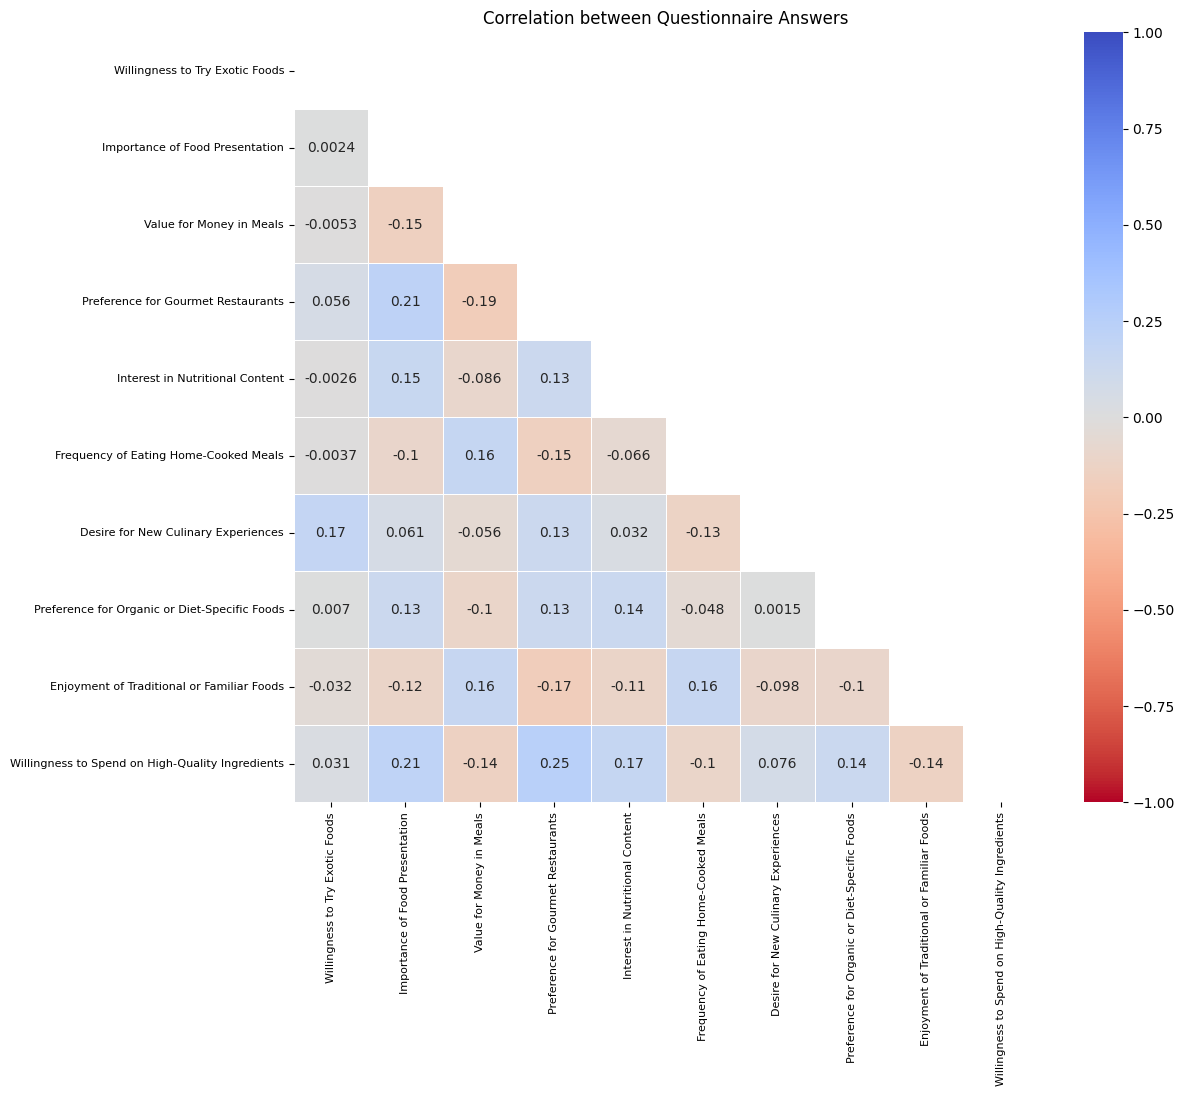

In [63]:
#Plotting the correlation matrix and only viewing the lower triangle
correlation_matrix = final_answers.drop(['personality', 'username'], axis=1).corr(method='spearman')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask,annot=True, cmap='coolwarm_r', linewidths=.5, vmin=-1, vmax=1)

# Reduce the font size of the labels.
plt.xticks(fontsize=8)  # Adjust the font size for x-axis labels.
plt.yticks(fontsize=8)  # Adjust the font size for y-axis labels.
plt.title("Correlation between Questionnaire Answers")
plt.show()

> It appears that there are several factors that typically are found together, namely the preference for gourmet restaurants, the importance given to the presentation of a meal and the willingness to spend on high quality ingredients. Moreover, it seems that clients who prefer home-cooked meals are not so enthusiastic of new culinary experiences, while the preference for gourmet restaurants typically implies less preoccupation with the monetary value of the meal.

#### Percentage of Answers by Question

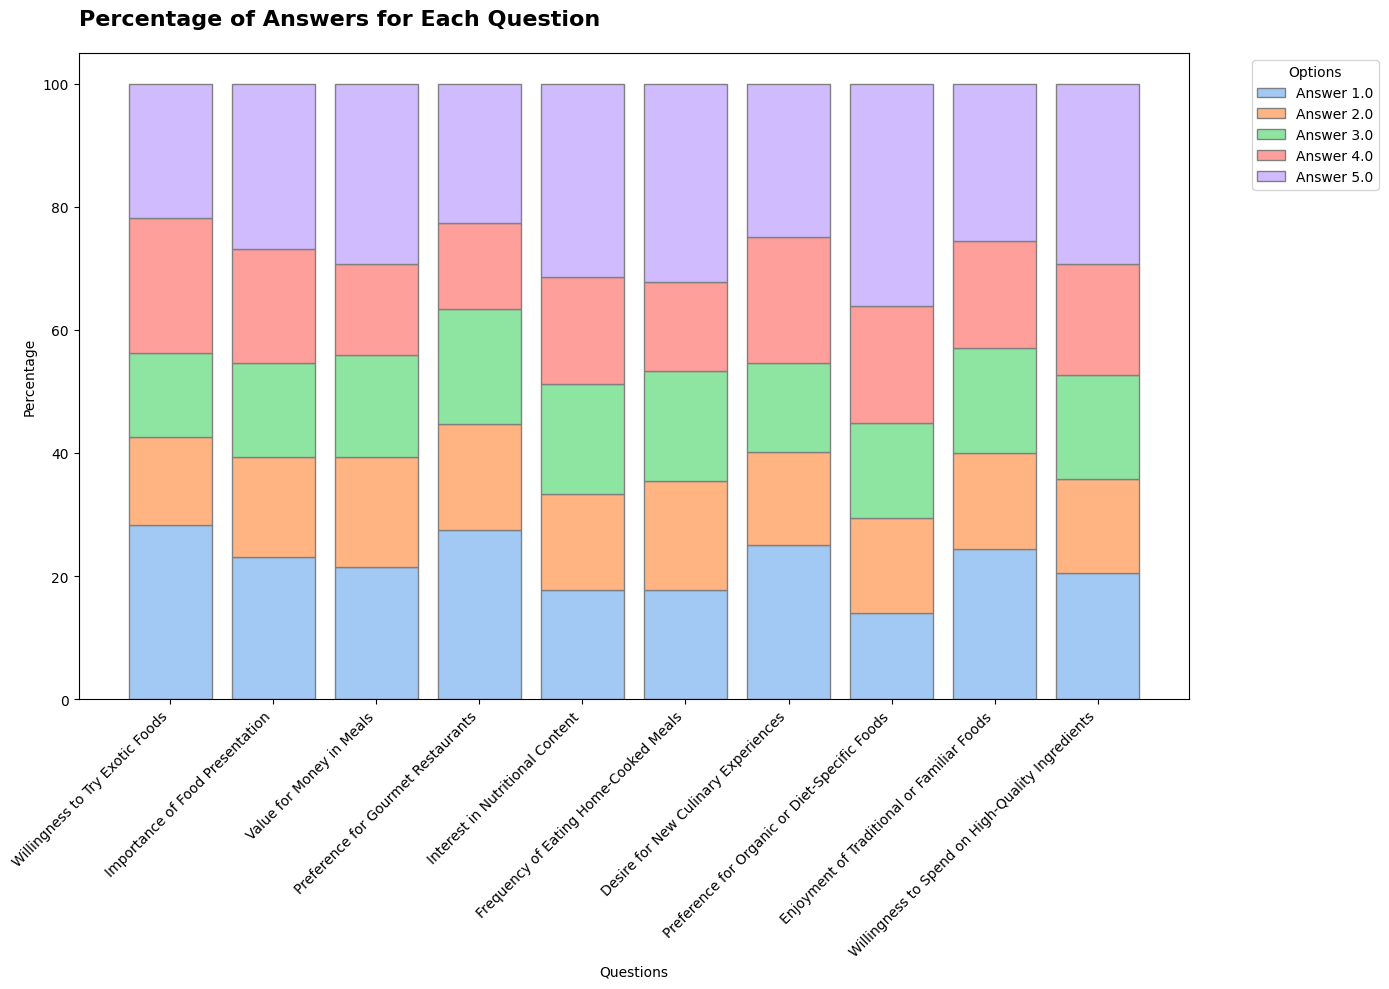

In [64]:
#Find the percentage of each answer for each question
rating_counts = final_answers.drop(['personality', 'username'], axis=1).apply(pd.Series.value_counts)
total_responses = final_answers.drop(['personality', 'username'], axis=1).count()
feature_percentages = (rating_counts / total_responses) * 100
feature_percentages = feature_percentages.T
feature_percentages.fillna(0, inplace=True)

#Plot the percentage of each answer for each question through a stacked bar chart
plt.figure(figsize=(14, 10))

bottoms_corrected = pd.Series([0]*len(feature_percentages), index=feature_percentages.index)
colors = sns.color_palette("pastel")

for i, column in enumerate(feature_percentages.columns):
    plt.bar(feature_percentages.index, feature_percentages[column], 
            bottom=bottoms_corrected, label=f'Answer {column}', color=colors[i % len(colors)], edgecolor='gray')
    bottoms_corrected += feature_percentages[column]

plt.title('Percentage of Answers for Each Question', fontsize=16, fontweight='bold', pad=20, loc='left')
plt.xlabel('Questions')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Options', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

> It seems that the question most often aswered with "Strongly Agree" is ``Preference for Organic or Diet-Specific Foods``, while the questions most reocurrently answered with "Strongly Disagree" are ``Willingness to Try Exotic Foods`` and ``Preference for Gourmet Restaurants``. The distribution of each type of answer per question seems more or less consistent.

#### Distribution of Answers by Food Personality Type per Question

In [65]:
melted = pd.melt(final_answers.drop('username', axis=1), id_vars='personality', value_name='Answer', var_name='Question')

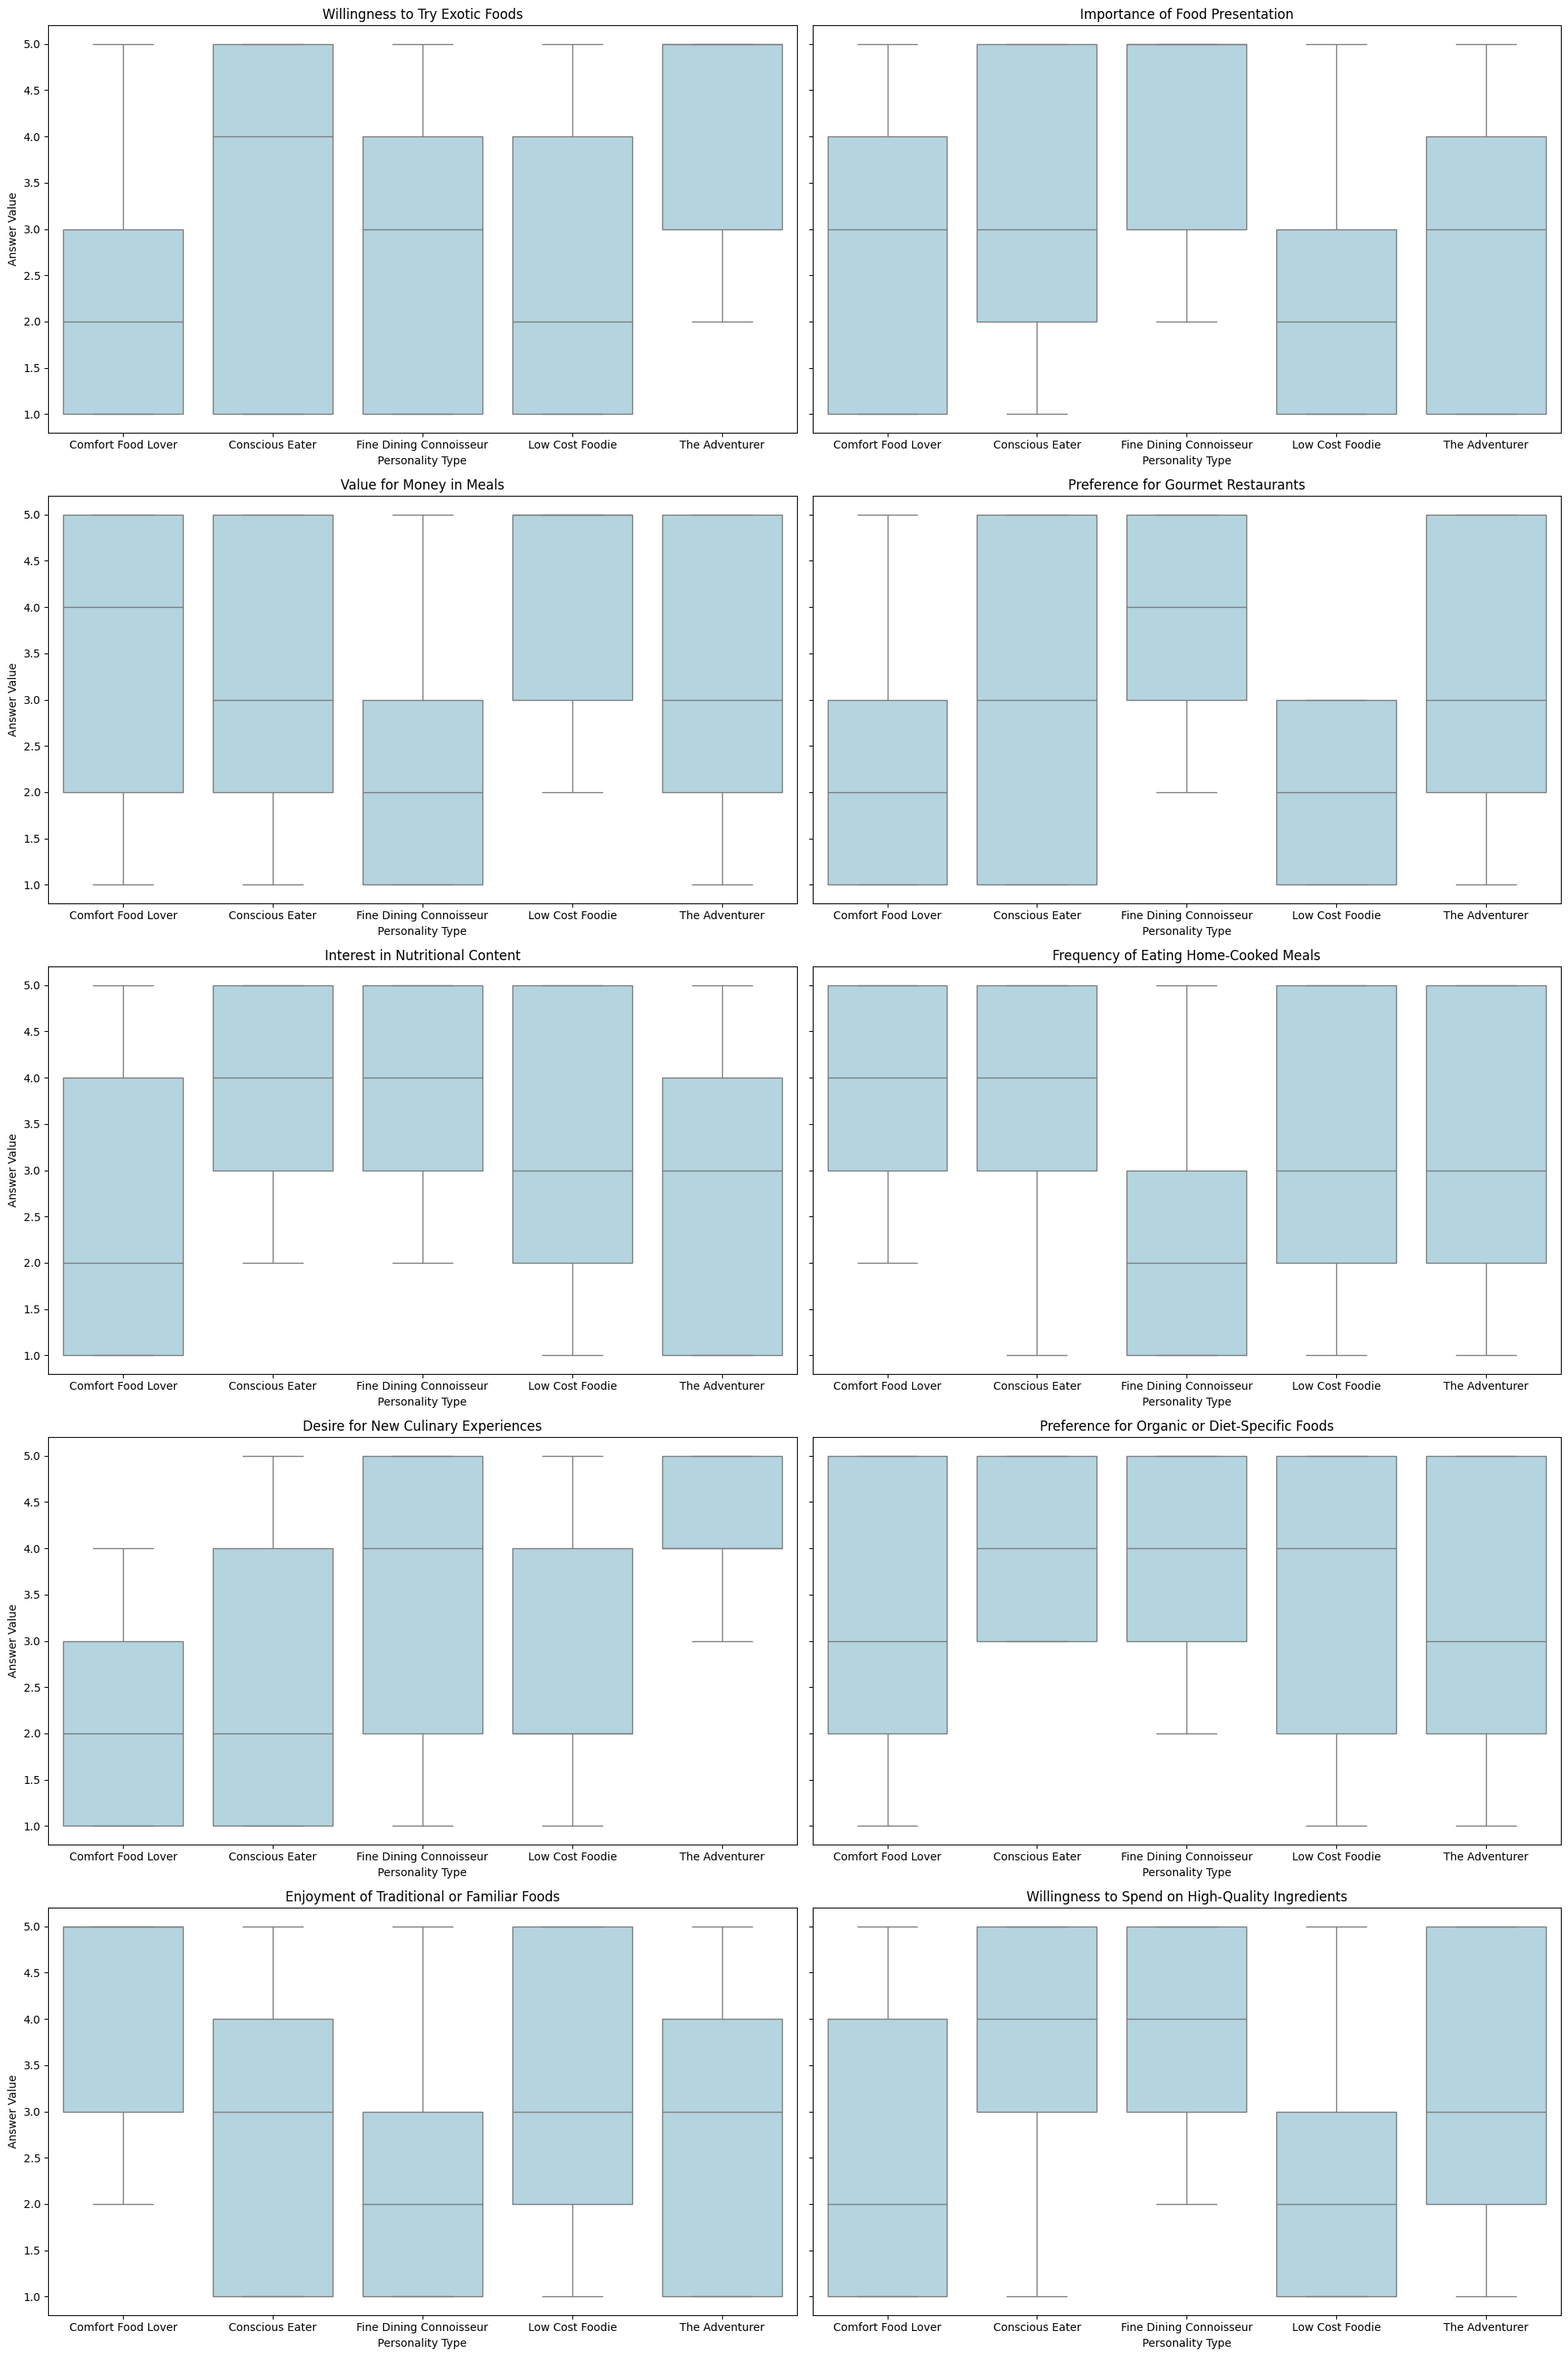

In [66]:
#Plot the distribution of answers per question and personality type with boxplots
questions = list(melted['Question'].unique())

fig, axes = plt.subplots(5, 2, figsize=(20, 30), sharey=True)
axes = axes.flatten()

for i in range(0, len(questions) ):
    ax = axes[i]
    sns.boxplot(data=melted[melted['Question'] == f'{questions[i]}'], x='personality', y='Answer', ax=ax , color= 'lightblue')
    ax.set_title(f'{questions[i]}')
    ax.set_xlabel('Personality Type')
    ax.set_ylabel('Answer Value')

plt.tight_layout()

plt.show()

It is already possible to detect some differences between personalities and common answers. In median terms, ``Low Cost Foodies`` are less willing to spend on high quality ingredients, and tend to prefer less Gourmet Restaurant, valuing the money spent to get a given meal. ``Comfort Food Lovers`` are fans of traditional/familiar food and express less desire to experiment with new or exotic foods.  ``Fine-Dining Connoisseurs`` privilege less the money spent por meal and prefer to dine-out rather than eating at home, as well as they give higher importance to food presentation. ``Conscious Eaters`` are willing to spend more on high quality ingredients and incorporate diet-specific elements within their meals with regularity. Finally, ``The Adventurer'``s like to experiment with different cuisine styles.

### 4. 🍽️ Building the Predictive Model and Evaluating it <a class="anchor" id="classifier"></a>
[Back to TOC](#toc)

> Let's first separate the target variable from the features.

In [67]:
#Separating the features from the target (and disregarding the username column)
X = final_answers.drop(['personality', 'username'], axis=1)
y = final_answers['personality']

> To evaluate the model consistently, K-Fold cross-validation will be used.

In [68]:
#Training a Random Forest Classifier using 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_val_scores = []
accuracy_train_scores = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
     print(f" -----------  Training for Fold {i} ----------- ")
     X_train, X_val = X.iloc[train_index], X.iloc[test_index]
     y_train, y_val = y.iloc[train_index], y.iloc[test_index]
     rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42, min_samples_leaf=10, criterion='gini')
     rf.fit(X_train, y_train)
     y_train_pred = rf.predict(X_train)
     y_val_pred = rf.predict(X_val)
     accuracy_val_scores.append(accuracy_score(y_val, y_val_pred))
     accuracy_train_scores.append(accuracy_score(y_train, y_train_pred))
     print(f"Train Accuracy Score: {accuracy_train_scores[i]}")
     print(f"Validation Accuracy Score: {accuracy_val_scores[i]}")
     print(f"Classification Report: \n {classification_report(y_val, y_val_pred)}")
print(f"Average Training Accuracy Score: {np.mean(accuracy_train_scores)}")
print(f"Average Validation Accuracy Score: {np.mean(accuracy_val_scores)}")

 -----------  Training for Fold 0 ----------- 
Train Accuracy Score: 0.8433081059549891
Validation Accuracy Score: 0.8109938259310894
Classification Report: 
                          precision    recall  f1-score   support

     Comfort Food Lover       0.85      0.78      0.81      1027
        Conscious Eater       0.77      0.80      0.78      1025
Fine Dining Connoisseur       0.84      0.88      0.86      1028
        Low Cost Foodie       0.80      0.83      0.81       973
         The Adventurer       0.80      0.77      0.79       968

               accuracy                           0.81      5021
              macro avg       0.81      0.81      0.81      5021
           weighted avg       0.81      0.81      0.81      5021

 -----------  Training for Fold 1 ----------- 
Train Accuracy Score: 0.8447520414260108
Validation Accuracy Score: 0.7962557259510058
Classification Report: 
                          precision    recall  f1-score   support

     Comfort Food Lover     

> Now that we found a moderately-accurate model, with approximately, and on average, an 80% of accuracy in the validation set, let's examine the confusion matrix of the last fold's validation predictions to get a better understanding of which classes the model is able to capture best.

In [69]:
#Preparing the data to plot the confusion matrix
classes = list(y.unique())
matrix = confusion_matrix(y_val, y_val_pred)
row_totals = matrix.sum(axis=1)
matrix_percentages = matrix / row_totals[:, None] * 100 
#Create DataFrames from the confusion matrices
df_confusion = pd.DataFrame(matrix, index=classes, columns=classes)
df_percentages = pd.DataFrame(matrix_percentages, index=classes, columns=classes)
annotations = df_confusion.astype(str) + "\n" + df_percentages.round(2).astype(str) + "%"

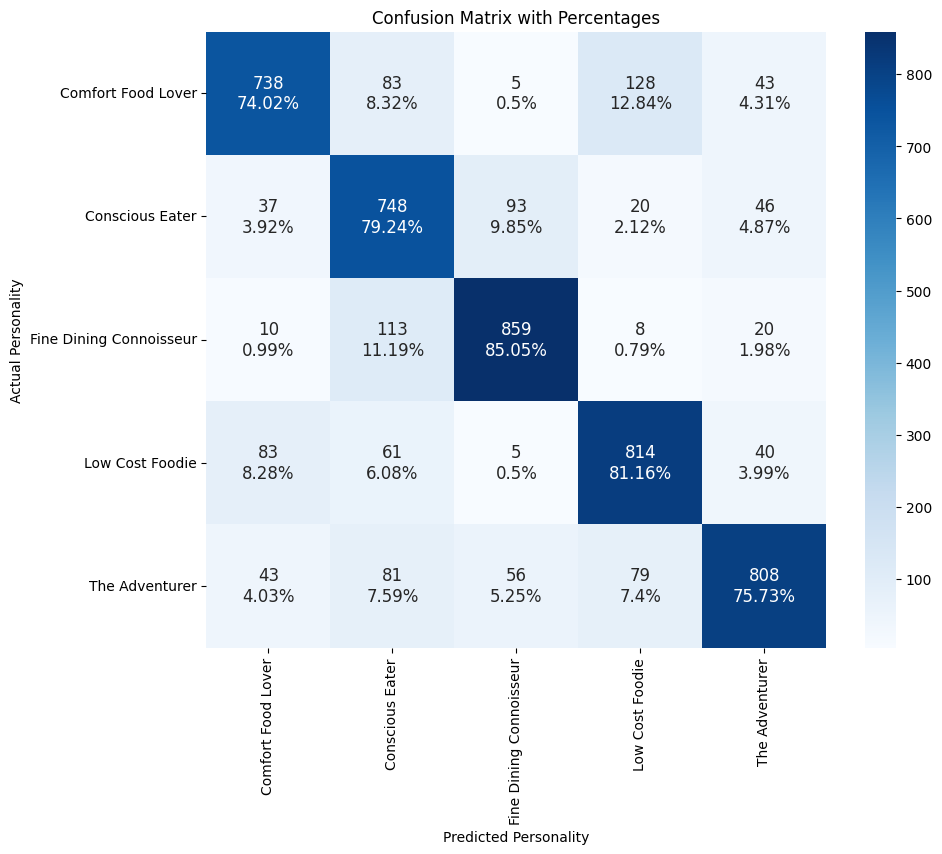

In [70]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=annotations, fmt='', cmap='Blues', annot_kws={"size": 12}, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Personality')
plt.ylabel('Actual Personality')
plt.title('Confusion Matrix with Percentages')
plt.show()

> It appears that the model is being able to capture relatively well the distinction between different personalities, performing less accurately for observations within "Comfort Food Lover" personality, often confusing it with "Low Cost Foodies". 

### 5. 🍽️ Training and Saving the final model for Future Predictions <a class="anchor" id="save"></a>
[Back to TOC](#toc)

> Now that the model's parameters are defined, it will be trained on the entire data and saved for future predictions.

In [71]:
#Re-train the model with the complete data
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42, min_samples_leaf=10, criterion='gini')
rf.fit(X, y)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=150,
                       random_state=42)

In [112]:
with open('personality_classification_model.pkl', 'wb') as f:
    pickle.dump(rf, f)